<a href="https://colab.research.google.com/github/sumu97/Study/blob/main/p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 테슬라 주가예측 시스템 with 구글 트렌드

1. 컬럼 기준으로 데이터 정렬
2. 머신러닝 베이스 모델 (회귀모델 혹은 분류모델) 정의
3. 머신러닝 모델 선택 및 고도화
4. 결과 도출 및 시각화
5. 웹 구동

## 1. EDA

In [ ]:
%%capture
from google.colab import drive
import io
import pandas as pd
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
drive.mount('/content/drive')

In [ ]:
import pandas as pd
# 검색 데이터 [날짜, 검색량]
df_a = pd.read_csv('/content/drive/MyDrive/데이터/p1/tsla.csv')
# 주가 데이터 [날짜, 종가, 시가, 고가, 저가, 거래량, 변동률 ]
df_b = pd.read_csv('/content/drive/MyDrive/데이터/p1/TSLA Historical Data2.csv')

In [ ]:
# 검색 데이터를 거꾸로
df_a = df_a.sort_values(by=['Date'],axis = 0,ascending=False)
# 주가 데이터를 거꾸로
df_a = df_a.reset_index(drop=True, inplace = False)
# 검색, 주가 데이터 합치기
df = pd.concat([df_a,df_b], axis = 1, ignore_index = True)
# 컬럼명 재설정
df.columns = ['Date','Search','Day(notuse)','Price','Open','High','Low','Vol','Change']
# 필요없는 컬럼 제거
df = df.drop(['Day(notuse)'],axis = 1)
# 데이터 시간순 정렬
df = df.sort_values(by=['Date'],axis = 0,ascending=True)

In [ ]:
# 자료형 확인
df.dtypes

Date      object
Search     int64
Price     object
Open      object
High      object
Low       object
Vol       object
Change    object
dtype: object

In [ ]:
# 자료형 변경
import datetime
import numpy as np

for col in df.columns:
  temp_list = []
  for i in df[col]:
    try: # datetime 우선 처리
      temp = datetime.datetime.strptime(i, '%Y-%m-%d').date()
      temp_list.append(temp) # datetime 로 변경된 자료형을 list에 저장
    except:
      try: # 데이터 조정
        temp = i.replace('M','')
        temp = temp.replace(',','')
        temp = temp.replace('B','1000')
        temp = temp.replace('%','')
        temp = float(temp)
        temp_list.append(temp)
      except: # 기존 int 형 데이터
          temp_list.append(i)
  df[col] = temp_list # 변경된 리스트를 col 에 저장

In [ ]:
# 변경된 자료형 확인
df.dtypes

Date       object
Search      int64
Price     float64
Open      float64
High      float64
Low       float64
Vol       float64
Change    float64
dtype: object

In [ ]:
df

,Date,Search,Price,Open,High,Low,Vol,Change
259,2017-02-19,12,51.40,55.09,56.69,50.04,187.59,-5.60
258,2017-02-26,9,50.31,49.63,50.97,48.40,143.15,-2.12
257,2017-03-05,6,48.74,49.58,50.78,48.60,87.45,-3.12
256,2017-03-12,6,52.30,48.96,53.15,48.56,147.91,7.30
255,2017-03-19,5,52.63,52.12,52.96,50.05,117.75,0.63
...,...,...,...,...,...,...,...,...
4,2022-01-09,20,1049.61,1000.00,1115.60,980.00,137.25,2.21
3,2022-01-16,17,943.90,1026.60,1070.79,940.50,105.45,-10.07
2,2022-01-23,34,846.35,904.76,987.69,792.01,208.58,-10.33
1,2022-01-30,23,923.32,872.59,943.70,862.45,24.54,9.09


In [ ]:
# 인덱스 초기화
df = df.reset_index(drop = True)
df

,Date,Search,Price,Open,High,Low,Vol,Change
0,2017-02-19,12,51.40,55.09,56.69,50.04,187.59,-5.60
1,2017-02-26,9,50.31,49.63,50.97,48.40,143.15,-2.12
2,2017-03-05,6,48.74,49.58,50.78,48.60,87.45,-3.12
3,2017-03-12,6,52.30,48.96,53.15,48.56,147.91,7.30
4,2017-03-19,5,52.63,52.12,52.96,50.05,117.75,0.63
...,...,...,...,...,...,...,...,...
255,2022-01-09,20,1049.61,1000.00,1115.60,980.00,137.25,2.21
256,2022-01-16,17,943.90,1026.60,1070.79,940.50,105.45,-10.07
257,2022-01-23,34,846.35,904.76,987.69,792.01,208.58,-10.33
258,2022-01-30,23,923.32,872.59,943.70,862.45,24.54,9.09


## 2.Data Wrangling

어떤 특성을 만들 것인가?  
1주 뒤, 3주 뒤, 5주 뒤, 10주 뒤 가격이 오르면 1, 아니면 0 을 반환하는 특성을 만들어 보자.

In [ ]:
def price_go(much,target_feature): # 가격변화 함수(몇 주 뒤, 비교할 특성)
  week = []
  for i in range(len(target_feature)):
    try:
      if target_feature[i] < target_feature[i+much]:
        week.append(1)
      elif target_feature[i] >= target_feature[i+much]:
        week.append(0)
    except:
      week.append(np.nan)
  return week # 몇 주 뒤 커지면 1, 아니면 0, 모르면 Nan 반환

In [ ]:
df['one'] = price_go(1,df.Price)
df['thr'] = price_go(3,df.Price)
df['fiv'] = price_go(5,df.Price)
df['ten'] = price_go(10,df.Price)

In [ ]:
df

,Date,Search,Price,Open,High,Low,Vol,Change,one,thr,fiv,ten
0,2017-02-19,12,51.40,55.09,56.69,50.04,187.59,-5.60,0.0,1.0,1.0,1.0
1,2017-02-26,9,50.31,49.63,50.97,48.40,143.15,-2.12,0.0,1.0,1.0,1.0
2,2017-03-05,6,48.74,49.58,50.78,48.60,87.45,-3.12,1.0,1.0,1.0,1.0
3,2017-03-12,6,52.30,48.96,53.15,48.56,147.91,7.30,1.0,1.0,1.0,1.0
4,2017-03-19,5,52.63,52.12,52.96,50.05,117.75,0.63,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
255,2022-01-09,20,1049.61,1000.00,1115.60,980.00,137.25,2.21,0.0,0.0,NaN,NaN
256,2022-01-16,17,943.90,1026.60,1070.79,940.50,105.45,-10.07,0.0,0.0,NaN,NaN
257,2022-01-23,34,846.35,904.76,987.69,792.01,208.58,-10.33,1.0,NaN,NaN,NaN
258,2022-01-30,23,923.32,872.59,943.70,862.45,24.54,9.09,0.0,NaN,NaN,NaN


이동평균선 Feature 추가

In [ ]:
def moving_avg(much,target_feature): # 이동평균선 함수(몇 주 치, 비교할 특성)
  target_list = []
  for i in range(len(target_feature)):
    feature_list = []
    try:
      for l in range(much+1):
        feature_list.append(target_feature[i-l])
      target_list.append(round(np.mean(feature_list),2))
    except:
      target_list.append(np.nan)
  return target_list

In [ ]:
df['avg_one'] = moving_avg(1, df.Price)
df['avg_thr'] = moving_avg(3, df.Price)
df['avg_fiv'] = moving_avg(5, df.Price)
df['avg_ten'] = moving_avg(10, df.Price)

In [ ]:
df

,Date,Search,Price,Open,High,Low,Vol,Change,one,thr,fiv,ten,avg_one,avg_thr,avg_fiv,avg_ten
0,2017-02-19,12,51.40,55.09,56.69,50.04,187.59,-5.60,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,2017-02-26,9,50.31,49.63,50.97,48.40,143.15,-2.12,0.0,1.0,1.0,1.0,50.86,NaN,NaN,NaN
2,2017-03-05,6,48.74,49.58,50.78,48.60,87.45,-3.12,1.0,1.0,1.0,1.0,49.53,NaN,NaN,NaN
3,2017-03-12,6,52.30,48.96,53.15,48.56,147.91,7.30,1.0,1.0,1.0,1.0,50.52,50.69,NaN,NaN
4,2017-03-19,5,52.63,52.12,52.96,50.05,117.75,0.63,1.0,1.0,1.0,1.0,52.46,51.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2022-01-09,20,1049.61,1000.00,1115.60,980.00,137.25,2.21,0.0,0.0,NaN,NaN,1038.28,1050.09,1024.99,1058.13
256,2022-01-16,17,943.90,1026.60,1070.79,940.50,105.45,-10.07,0.0,0.0,NaN,NaN,996.75,1019.31,1012.80,1032.84
257,2022-01-23,34,846.35,904.76,987.69,792.01,208.58,-10.33,1.0,NaN,NaN,NaN,895.12,966.70,998.43,1015.83
258,2022-01-30,23,923.32,872.59,943.70,862.45,24.54,9.09,0.0,NaN,NaN,NaN,884.84,940.80,974.49,996.40


생성된 결측치 제거

In [ ]:
# 위, 아래 20개 행 제거됨
df = df.dropna(axis = 0)
df

,Date,Search,Price,Open,High,Low,Vol,Change,one,thr,fiv,ten,avg_one,avg_thr,avg_fiv,avg_ten
10,2017-04-30,13,61.67,62.98,65.53,58.15,218.38,-1.82,1.0,1.0,1.0,1.0,62.24,61.60,60.43,56.18
11,2017-05-07,9,64.96,62.18,65.40,61.16,156.50,5.33,0.0,1.0,1.0,1.0,63.32,62.64,61.98,57.41
12,2017-05-14,7,62.17,63.68,64.04,61.06,144.14,-4.29,1.0,1.0,1.0,1.0,63.56,62.90,62.26,58.49
13,2017-05-21,7,65.03,62.56,65.10,60.70,132.53,4.60,1.0,1.0,1.0,1.0,63.60,63.46,62.96,59.97
14,2017-05-28,7,67.97,65.20,68.98,65.15,154.72,4.52,1.0,1.0,0.0,1.0,66.50,65.03,64.10,61.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2021-10-31,35,1222.09,1145.00,1243.49,1118.66,180.44,9.70,0.0,0.0,0.0,0.0,1168.04,1022.20,941.58,851.38
246,2021-11-07,39,1033.42,1149.79,1197.00,987.31,183.32,-15.44,1.0,0.0,0.0,0.0,1127.76,1069.80,984.62,880.60
247,2021-11-14,26,1137.06,1017.63,1138.72,978.60,135.30,10.03,0.0,0.0,0.0,0.0,1085.24,1126.64,1043.21,917.29
248,2021-11-21,18,1081.92,1162.33,1201.95,1062.00,103.49,-4.85,0.0,0.0,0.0,0.0,1109.49,1118.62,1083.03,948.71


Feature, Label, Train, Test 분리  
새로 생성된 4개의 feature는 각각 별도의 label으로 설정  
Date는 이미 인덱스에 반영되어있어 무시해도 됨 -> 날짜기준으로 잘라먹으려면 필요하긴 한데.. 단순화해도 좋을듯  
Feature = Search, Price, Open, High, Low, Vol, Change.   
Label_1 = one.   
Label_3 = thr.   
Label_5 = fiv.   
Label_10 = ten

Nan 값 때문에 검증 정확도 계산 불가  
해결방안 : 데이터 자르기  
1, 3, 5, 10일로 다양한 Label 값, 자동으로 잘라주는 함수 필요  
-> 쓸데없이 복잡, 그냥 X_test_1 등으로 특성 별도 생성해 해결

In [ ]:
# Train Test Split * 0.7
train = df[0:int(len(df)*0.7)]
test = df[int(len(df)*0.7):]
print(train.shape,test.shape)
features = ['Search','Price','Open','High','Low','Vol','Change','avg_one','avg_thr','avg_fiv','avg_ten']
# Train Data Set
X_train = train[features]
y_train_1 = train['one']
y_train_3 = train['thr']
y_train_5 = train['fiv']
y_train_10 = train['ten']
# Test Data Set_1
X_test_1 = test[features]
X_test_1 = X_test_1[:-1]
y_test_1 = test['one']
y_test_1 = y_test_1[:-1]

# Test Data Set_3
X_test_3 = test[features]
X_test_3 = X_test_3[:-3]
y_test_3 = test['thr']
y_test_3 = y_test_3[:-3]

# Test Data Set_5
X_test_5 = test[features]
X_test_5 = X_test_5[:-5]
y_test_5 = test['fiv']
y_test_5 = y_test_5[:-5]

# Test Data Set_10
X_test_10 = test[features]
X_test_10 = X_test_10[:-10]
y_test_10 = test['ten']
y_test_10 = y_test_10[:-10]

(168, 16) (72, 16)


## 3. Data Inspection

Target = one, thr, fiv, tem 등 0과 1로 이루어진 '분류' 문제를 다루기 때문에,  
 Random Forest Classifier 를 이용해 분류해보도록 하자.

In [ ]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas.util.testing as tm # 디버그 문구때문에 추가함
from xgboost import XGBClassifier # model
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # model 평가
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Baseline Model 학습

In [ ]:
# 모델 (RandomForestClassifier) 학습 
pipe = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf=5, random_state=2, oob_score=True)
)

In [ ]:
# 1주 뒤 예측
pipe.fit(X_train, y_train_1)
print('1주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_1))
print('검증 정확도: ', pipe.score(X_test_1, y_test_1))
# 3주 뒤 예측
pipe.fit(X_train, y_train_3)
print('3주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_3))
print('검증 정확도: ', pipe.score(X_test_3, y_test_3))
# 5주 뒤 예측
pipe.fit(X_train, y_train_5)
print('5주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_5))
print('검증 정확도: ', pipe.score(X_test_5, y_test_5))
# 10주 뒤 예측
pipe.fit(X_train, y_train_10)
print('10주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_10))
print('검증 정확도: ', pipe.score(X_test_10, y_test_10))

1주 예측
훈련 정확도:  0.8035714285714286
검증 정확도:  0.5211267605633803
3주 예측
훈련 정확도:  0.875
검증 정확도:  0.6376811594202898
5주 예측
훈련 정확도:  0.8392857142857143
검증 정확도:  0.7164179104477612
10주 예측
훈련 정확도:  0.8809523809523809
검증 정확도:  0.6129032258064516


훈련은 상당히 정확하게 분류되는데 반해 검증시 예측 불가능  
-> 특성(이동평균선) 추가 이후 검증정확도 10~20% 상승!

In [ ]:
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2)
)
dists = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1)
}
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)
clf.fit(X_train, y_train_1);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 0.6903936234514721, 'randomforestclassifier__n_estimators': 209, 'simpleimputer__strategy': 'most_frequent'}
MAE:  0.5892857142857143


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,36,10,44,14,11,30,40,5,46,6,45,3,2,48,43,15,21,22,24,12,42,32,8,41,28,27,16,25,23,20,9,35,38,39,0,33,31,29,19,17,1,49,37,13,47,34,7,4,26,18
mean_fit_time,0.288014,0.481455,0.47109,0.602132,0.587781,0.722629,0.298967,1.013583,0.91571,0.537214,0.712221,0.618263,0.488069,1.123787,0.593457,0.632111,0.573311,0.919471,0.737845,0.895977,0.937686,0.894014,0.666049,0.276126,0.387442,1.047646,0.226046,1.024674,0.37565,0.391339,0.344879,0.343386,0.137733,0.311656,0.549584,0.83656,0.978923,0.591885,1.044775,1.197059,0.65364,0.472966,0.517204,0.474057,0.816191,0.31644,0.415399,0.246496,0.659484,0.820453
std_fit_time,0.002424,0.00077,0.006826,0.010791,0.008546,0.011675,0.001688,0.016658,0.009095,0.003571,0.005671,0.010041,0.013907,0.007678,0.011637,0.005907,0.005918,0.015269,0.014778,0.005188,0.013944,0.007116,0.004417,0.006257,0.007171,0.00681,0.01204,0.011458,0.005264,0.009368,0.011124,0.010194,0.00512,0.002477,0.003918,0.003458,0.009498,0.007838,0.004542,0.022265,0.010831,0.030131,0.0011,0.004262,0.00622,0.001643,0.009792,0.006223,0.009186,0.004284
mean_score_time,0.027104,0.038046,0.036954,0.046634,0.046537,0.053437,0.02659,0.085774,0.08676,0.042102,0.058168,0.046281,0.037274,0.08082,0.043982,0.04822,0.044594,0.075653,0.05865,0.077975,0.078941,0.069622,0.058374,0.025829,0.033568,0.084602,0.022553,0.082433,0.032319,0.033844,0.029315,0.032839,0.014101,0.028969,0.047654,0.068593,0.079335,0.046565,0.080784,0.091691,0.050159,0.035202,0.043639,0.040274,0.070199,0.031859,0.032866,0.022886,0.056577,0.06768
std_score_time,0.004107,0.001425,0.000618,0.001524,0.002107,0.000967,0.00137,0.006891,0.004348,0.000753,0.001013,0.000786,0.000552,0.004306,0.000477,0.000439,0.002157,0.003643,0.001404,0.004422,0.003247,0.002362,0.000395,0.001984,0.001265,0.002725,0.00169,0.00407,0.001562,0.001989,0.000822,0.000942,0.000241,0.004107,0.000258,0.001199,0.001589,0.001097,0.003931,0.001779,0.000208,0.009088,0.001814,0.000611,0.003198,0.004985,0.001251,0.003472,0.003288,0.001988
param_randomforestclassifier__max_depth,10,15,10,None,15,10,5,10,5,10,None,None,5,15,20,10,20,10,5,5,5,5,None,5,None,5,None,10,10,5,None,15,None,15,None,5,5,10,5,10,5,None,None,10,None,15,None,10,10,15
param_randomforestclassifier__max_features,0.720591,0.690394,0.648536,0.71429,0.718146,0.932424,0.567944,0.486309,0.062416,0.714349,0.390001,0.893308,0.814361,0.994894,0.962244,0.889806,0.956025,0.530095,0.624583,0.530716,0.509096,0.68897,0.058541,0.30344,0.332368,0.346894,0.337791,0.548971,0.499538,0.533343,0.348069,0.161199,0.142292,0.5236,0.176904,0.241657,0.290183,0.839128,0.887126,0.981473,0.903294,0.368186,0.330971,0.27866,0.441954,0.42223,0.494417,0.525195,0.189241,0.203918
param_randomforestclassifier__n_estimators,127,209,207,263,259,305,137,465,465,238,331,256,212,480,253,277,237,412,336,415,440,410,325,129,180,493,100,461,169,180,158,164,64,140,262,409,468,253,461,498,285,229,240,223,379,146,184,106,312,392
param_simpleimputer__strategy,mean,most_frequent,mean,mean,most_frequent,most_frequent,most_frequent,mean,most_frequent,most_frequent,most_frequent,most_frequent,mean,most_frequent,median,mean,most_frequent,median,mean,mean,mean,mean,median,most_frequent,most_frequent,median,mean,mean,median,median,median,most_frequent,most_frequent,mean,mean,most_frequent,median,mean,median,median,median,most_frequent,mean,median,mean,most_frequent,mean,most_frequent,mean,median
params,"{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, '

In [ ]:
pipe = clf.best_estimator_

In [ ]:
# 1주 뒤 예측
pipe.fit(X_train, y_train_1)
print('1주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_1))
print('검증 정확도: ', pipe.score(X_test_1, y_test_1))
# 3주 뒤 예측
pipe.fit(X_train, y_train_3)
print('3주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_3))
print('검증 정확도: ', pipe.score(X_test_3, y_test_3))
# 5주 뒤 예측
pipe.fit(X_train, y_train_5)
print('5주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_5))
print('검증 정확도: ', pipe.score(X_test_5, y_test_5))
# 10주 뒤 예측
pipe.fit(X_train, y_train_10)
print('10주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_10))
print('검증 정확도: ', pipe.score(X_test_10, y_test_10))

1주 예측
훈련 정확도:  1.0
검증 정확도:  0.4647887323943662
3주 예측
훈련 정확도:  1.0
검증 정확도:  0.5797101449275363
5주 예측
훈련 정확도:  1.0
검증 정확도:  0.7164179104477612
10주 예측
훈련 정확도:  1.0
검증 정확도:  0.6129032258064516


Randomized Search CV 하이퍼파라미터 튜닝을 해도 만족스럽지 못한 결과를 얻었다.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100, 1000],
           'max_depth' : [2, 4, 6, 8, 16, 32],
           'min_samples_leaf' : [2,4,8, 16, 32],
           'min_samples_split' : [2, 4, 8, 16, 32]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train_1)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 2, 'min_samples_leaf': 32, 'min_samples_split': 2, 'n_estimators': 10}
최고 예측 정확도: 0.5714


In [ ]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
pipe = RandomForestClassifier(n_estimators = 10, 
                                max_depth = 2,
                                min_samples_leaf = 32,
                                min_samples_split = 2,
                                random_state = 0,
                                n_jobs = -1)
pipe.fit(X_train, y_train_1)
pred = pipe.predict(X_test_1)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test_1,pred)))

예측 정확도: 0.6056


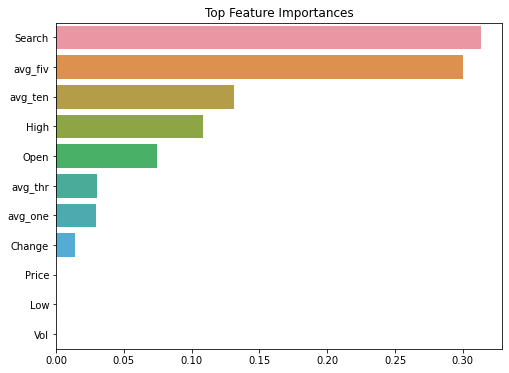

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = pipe.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
# 1주 뒤 예측
pipe.fit(X_train, y_train_1)
print('1주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_1))
print('검증 정확도: ', pipe.score(X_test_1, y_test_1))

1주 예측
훈련 정확도:  0.6309523809523809
검증 정확도:  0.6056338028169014


Grid Search 사용 결과, 1주 예측에서는 그나마 만족스러운 결과를 얻었다.  
과적합을 완전히 해결했으며,  
기대한 0.65 수준의 정확도는 아니지만, 0.58 정도의 정확도도 투자 목적으로 활용하기에는 충분하다.  
나머지는 애초에 맞춰서 모델링 한 게 아니기 때문에 그렇다 치자.  
그럼 3주 예측으로 모델링을 맞춰서 해보자.  
-> 이동평균선 특성 4개 추가 후 대박! 검증 정확도가 0.02 상승, 0.6을 넘겼고,  
초기에 가설 설정한대로 검색 데이터가 가장 큰 영향을 미쳤다!

In [ ]:
params = { 'n_estimators' : [10, 100, 1000],
           'max_depth' : [2, 4, 6, 8, 16, 32],
           'min_samples_leaf' : [2,4,8, 16, 32],
           'min_samples_split' : [2, 4, 8, 16, 32]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train_3)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
최고 예측 정확도: 0.3631


In [ ]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
pipe = RandomForestClassifier(n_estimators = 10, 
                                max_depth = 8,
                                min_samples_leaf = 4,
                                min_samples_split = 2,
                                random_state = 0,
                                n_jobs = -1)
pipe.fit(X_train, y_train_3)
pred = pipe.predict(X_test_3)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test_3,pred)))

예측 정확도: 0.6377


-> 이동평균선 특성 추가 후 예측 정확도 0.3 상승, 0.6377!

In [ ]:
# 3주 뒤 예측
pipe.fit(X_train, y_train_3)
print('3주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_3))
print('검증 정확도: ', pipe.score(X_test_3, y_test_3))

3주 예측
훈련 정확도:  0.9166666666666666
검증 정확도:  0.6376811594202898


-> 3주 뒤 예측도 매우 정밀해졌다.

3주 예측은 안되는것 같다.  
-> 이동평균선 특성 추가 후 된다.  
5주, 10주도 일단 해보자.

In [ ]:
params = { 'n_estimators' : [10, 100, 1000],
           'max_depth' : [2, 4, 6, 8, 16, 32],
           'min_samples_leaf' : [2,4,8, 16, 32],
           'min_samples_split' : [2, 4, 8, 16, 32]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train_5)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 2, 'min_samples_leaf': 32, 'min_samples_split': 2, 'n_estimators': 10}
최고 예측 정확도: 0.3214


In [ ]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
pipe = RandomForestClassifier(n_estimators = 10, 
                                max_depth = 2,
                                min_samples_leaf = 32,
                                min_samples_split = 2,
                                random_state = 0,
                                n_jobs = -1)
pipe.fit(X_train, y_train_5)
pred = pipe.predict(X_test_5)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test_5,pred)))

예측 정확도: 0.7164


In [ ]:
# 5주 뒤 예측
pipe.fit(X_train, y_train_5)
print('5주 예측')
print('훈련 정확도: ', pipe.score(X_train, y_train_5))
print('검증 정확도: ', pipe.score(X_test_5, y_test_5))

5주 예측
훈련 정확도:  0.6726190476190477
검증 정확도:  0.7164179104477612


In [ ]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [2, 4, 6, 8, 16, 32],
           'min_samples_leaf' : [2,4,8, 16, 32],
           'min_samples_split' : [2, 4, 8, 16, 32]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train_10)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 2, 'min_samples_leaf': 16, 'min_samples_split': 2, 'n_estimators': 100}
최고 예측 정확도: 0.4702


In [ ]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
pipe = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 2,
                                min_samples_leaf = 16,
                                min_samples_split = 2,
                                random_state = 0,
                                n_jobs = -1)
pipe.fit(X_train, y_train_10)
pred = pipe.predict(X_test_10)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test_10,pred)))

예측 정확도: 0.6129


10주까지는 안해도 알 것 같다..  
-> 해봐도 될 것 같다!  
--> 뭐가 잘못됬나...? 왜이렇게 높게 나오지..

1주 후 예측 : 0.605  
3주 후 예측 : 0.637  
5주 후 예측 : 0.716  
10주 후 예측 : 0.612

지금으로썬 적정 수준의 정확도를 확보한 것 같아 보인다.  
더 자세히, 세밀히 테스트 해보기 위해 쉽게 테스트 케이스를 만들어주는 함수를 만들어두자.  
입력값 : 두 기간을 입력하면 두 기간 사이의 각 값에 대해 모델 적용 및 예측을 시행  
출력값 : 백분율로 정확도를 환산해주는 함수

In [ ]:
X_train

,Search,Price,Open,High,Low,Vol,Change,avg_one,avg_thr,avg_fiv,avg_ten
10,13,61.67,62.98,65.53,58.15,218.38,-1.82,62.24,61.60,60.43,56.18
11,9,64.96,62.18,65.40,61.16,156.50,5.33,63.32,62.64,61.98,57.41
12,7,62.17,63.68,64.04,61.06,144.14,-4.29,63.56,62.90,62.26,58.49
13,7,65.03,62.56,65.10,60.70,132.53,4.60,63.60,63.46,62.96,59.97
14,7,67.97,65.20,68.98,65.15,154.72,4.52,66.50,65.03,64.10,61.39
...,...,...,...,...,...,...,...,...,...,...,...
173,21,200.18,183.56,203.84,181.70,290.35,7.01,193.62,182.84,175.76,160.83
174,18,191.95,199.99,202.40,187.43,208.98,-4.11,196.06,189.08,181.12,167.86
175,27,241.73,193.80,245.60,189.70,282.61,25.93,216.84,205.23,194.17,176.13
176,47,308.93,255.34,309.78,253.21,467.13,27.80,275.33,235.70,217.83,191.03


In [ ]:
df

,Date,Search,Price,Open,High,Low,Vol,Change,one,thr,fiv,ten,avg_one,avg_thr,avg_fiv,avg_ten
10,2017-04-30,13,61.67,62.98,65.53,58.15,218.38,-1.82,1.0,1.0,1.0,1.0,62.24,61.60,60.43,56.18
11,2017-05-07,9,64.96,62.18,65.40,61.16,156.50,5.33,0.0,1.0,1.0,1.0,63.32,62.64,61.98,57.41
12,2017-05-14,7,62.17,63.68,64.04,61.06,144.14,-4.29,1.0,1.0,1.0,1.0,63.56,62.90,62.26,58.49
13,2017-05-21,7,65.03,62.56,65.10,60.70,132.53,4.60,1.0,1.0,1.0,1.0,63.60,63.46,62.96,59.97
14,2017-05-28,7,67.97,65.20,68.98,65.15,154.72,4.52,1.0,1.0,0.0,1.0,66.50,65.03,64.10,61.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2021-10-31,35,1222.09,1145.00,1243.49,1118.66,180.44,9.70,0.0,0.0,0.0,0.0,1168.04,1022.20,941.58,851.38
246,2021-11-07,39,1033.42,1149.79,1197.00,987.31,183.32,-15.44,1.0,0.0,0.0,0.0,1127.76,1069.80,984.62,880.60
247,2021-11-14,26,1137.06,1017.63,1138.72,978.60,135.30,10.03,0.0,0.0,0.0,0.0,1085.24,1126.64,1043.21,917.29
248,2021-11-21,18,1081.92,1162.33,1201.95,1062.00,103.49,-4.85,0.0,0.0,0.0,0.0,1109.49,1118.62,1083.03,948.71


In [ ]:
def test_case(start_date, end_date, X_data, y_data): # 시작일, 종료일, 특성 데이터, 라벨 데이터
  pass